# Lab 05 Logistic Classification(Regression)
* Logistic Classfication은 True or False와 같은 Binary나 복수개의 다항 분류에 쓰입니다 (Bernoulli Distribution)

### 기본 Library 선언 및 Tensorflow 버전 확인

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

print(tf.__version__)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.10.0


### 강의에 설명할 Data입니다
* x_data가 2차원 배열이기에 2차원 공간에 표현하여 x1과 x2를 기준으로 y_data 0과 1로 구분하는 예제입니다
* Logistic Classification 통해 보라색과 노란색 y_data(Label)을 구분해 보겠습니다.
* Test 데이터는 붉은색의 위치와 같이 추론시 1의 값을 가지게 됩니다.

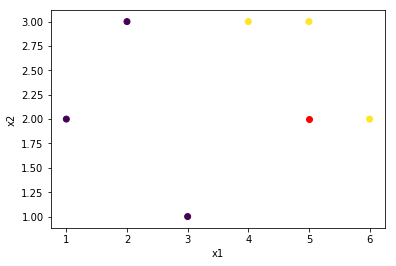

In [2]:
x_train = [[1, 2],
          [2, 3],
          [3, 1],
          [4, 3],
          [5, 3],
          [6, 2]]
y_train = [[0],
          [0],
          [0],
          [1],
          [1],
          [1]]

x_test = [[5,2]] 
y_test =  [[1]]


x1 = [x[0] for x in x_train]
x2 = [x[1] for x in x_train]

colors = [int(y[0] % 3) for y in y_train]
plt.scatter(x1,x2, c=colors)
plt.scatter(x_test[0][0],x_test[0][1], c="red")

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## 1. Tensorflow Session
### 위 Data를 기준으로 가설의 검증을 통해 Logistic Classification 모델을 만들도록 하겠습니다
* X,Y는 실재 학습에 쓰일 Data (placeholder)
* W와 b은 학습을 통해 생성되는 모델에 쓰이는 Wegith와 Bias (초기값을 variable : 0이나 Random값으로 가능 tf.random_normal([2, 1]) )

In [3]:
X = tf.placeholder(tf.float32, shape=[None, 2])
Y = tf.placeholder(tf.float32, shape=[None, 1])

W = tf.Variable(tf.zeros([2,1]), name='weight')
b = tf.Variable(tf.zeros([1]), name='bias')

### Sigmoid 함수를 가설로 선언합니다
* Sigmoid는 아래 그래프와 같이 0과 1의 값만을 리턴합니다 tf.sigmoid(tf.matmul(X, W) + b)와 같습니다

$$
\begin{align}
sigmoid(x) & = \frac{1}{1+e^{-x}}  \\\\\
\end{align}
$$

![sigmoid](https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg)

In [4]:
hypothesis  = tf.div(1., 1. + tf.exp(tf.matmul(X, W) + b))

### 가설을 검증할 Cost 함수를 정의합니다
$$
\begin{align}
cost(h(x),y) & = −log(h(x))  &  if  &  y=1 \\\\\
cost(h(x),y) & = -log(1−h(x))  &  if  &  y=0
\end{align}
$$

* 위 두수식을 합치면 아래과 같습니다
$$
\begin{align}
cost(h(x),y) & = −y log(h(x))−(1−y)log(1−h(x))
\end{align}
$$

In [5]:
cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) * tf.log(1 - hypothesis))

train = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

### 추론한 값은 0.5를 기준(Sigmoid 그래프 참조)로 0과 1의 값을 리턴합니다.
* Sigmoid 함수를 통해 예측값이 0.5보다 크면 1을 반환하고 0.5보다 작으면 0으로 반환합니다.

In [6]:
predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)

### 가설을 통해 실재 값과 비교한 정확도를 측정합니다

In [7]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.int32))

### Tensorflow를 통한 실행을 위해 Session를 선언합니다.
* 위의 Data를 Cost함수를 통해 학습시킨 후 모델을 생성합니다. 
* 새로운 Data를 통한 검증 수행 [5,2]의 Data로 테스트 수행 (그래프상 1이 나와야 정상입니다)
* 새로운 Data를 통한 검증 수행 [2,2]의 Data로 테스트 수행 (그래프상 0이 나와야 정상입니다)

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(10001):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_train, Y: y_train})
        if step % 1000 == 0:
            print(step, cost_val)

    # Accuracy report
    h, c, a = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_train, Y: y_train})
    print("\nHypothesis: ", h, "\nCorrect (Y): ", c, "\nAccuracy: ", a)
    print("[5,2] : ",   sess.run(predicted,feed_dict={X:x_test}))


0 0.6931472
1000 0.4144899
2000 0.34960732
3000 0.30138877
4000 0.26361898
5000 0.23360117
6000 0.20939068
7000 0.18956773
8000 0.17310147
9000 0.15924035
10000 0.1474307

Hypothesis:  [[0.02987642]
 [0.1576593 ]
 [0.30070737]
 [0.78328896]
 [0.9407705 ]
 [0.98057085]] 
Correct (Y):  [[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]] 
Accuracy:  1
[5,2] :  [[1.]]


## 2. Tensorflow Estimator
### Tensorflow Estimator API를 통해 Logistic Regression을 실행해보도록 해보자
* 먼저 X 데이터의 크기와 Label을 지정한다

In [9]:
x_label = [tf.feature_column.numeric_column('x', shape =[2])]

### Estimator는 LinearClassifier 통해 Logistic Regression을 선언한다

In [10]:
estimator = tf.estimator.LinearClassifier(feature_columns=x_label)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp0bg2x_b2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3c0519fef0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### 학습시킬 X와 Y에 대한 값과 학습할 횟수를 정의한다.(shuffle는 Data의 순차여부 선택)
* 학습 데이터 input_func와 테스트 데이터 input_func_test를 정의한다

In [11]:
input_func = tf.estimator.inputs.numpy_input_fn(x={'x':np.array(x_train)},y=np.array(y_train), num_epochs=10000, shuffle=False)
input_func_test = tf.estimator.inputs.numpy_input_fn(x={'x':np.array(x_test)},y=np.array(y_test), num_epochs=1, shuffle=False)

### 학습을 실행한다

In [12]:
estimator.train(input_fn=input_func)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp0bg2x_b2/model.ckpt.
INFO:tensorflow:loss = 88.722855, step = 1
INFO:tensorflow:global_step/sec: 573.733
INFO:tensorflow:loss = 34.385498, step = 101 (0.176 sec)
INFO:tensorflow:global_step/sec: 823.323
INFO:tensorflow:loss = 25.384941, step = 201 (0.121 sec)
INFO:tensorflow:global_step/sec: 809.983
INFO:tensorflow:loss = 20.99355, step = 301 (0.124 sec)
INFO:tensorflow:global_step/sec: 777.004
INFO:tensorflow:loss = 18.37023, step = 401 (0.128 sec)
INFO:tensorflow:Saving checkpoints for 469 into /tmp/tmp0bg2x_b2/model.ckpt.
INFO:tensorflow:Loss for final step: 12.40913.


### 학습에 대한 평가 수행 (학습데이터로 평가)

In [13]:
results = estimator.evaluate(input_fn=input_func)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-19-07:16:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0bg2x_b2/model.ckpt-469
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-19-07:16:14
INFO:tensorflow:Saving dict for global step 469: accuracy = 1.0, accuracy_baseline = 0.5, auc = 1.0, auc_precision_recall = 1.0, average_loss = 0.12914236, global_step = 469, label/mean = 0.5, loss = 16.52141, precision = 1.0, prediction/mean = 0.52867335, recall = 1.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 469: /tmp/tmp0bg2x_b2/model.ckpt-469


### 학습 결과에 대한 Test 수행

In [14]:
predictions = estimator.predict(input_func_test)
for result in predictions:
    print(result)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0bg2x_b2/model.ckpt-469
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'logits': array([2.5232568], dtype=float32), 'logistic': array([0.92575616], dtype=float32), 'probabilities': array([0.07424379, 0.92575616], dtype=float32), 'class_ids': array([1]), 'classes': array([b'1'], dtype=object)}
